In [1]:
pip install --upgrade totalsegmentator pydicom numpy scikit-image

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pydicom
import logging
from scipy import ndimage
from skimage import measure, morphology, filters, exposure, restoration
from scipy.spatial.distance import directed_hausdorff
import time
import csv
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from sklearn.metrics import jaccard_score
import sqlite3
from PIL import Image
import io
from flask import Flask, request, jsonify, send_from_directory, render_template
import socket
from flask_wtf.csrf import generate_csrf
from werkzeug.utils import secure_filename

from dicom_processing import process_dicom_series, segmentation_pipeline

def segment_vessels_2d(image_2d):
    """
    Simple vessel segmentation using thresholding and morphological operations.
    This is a placeholder and should be replaced with a more sophisticated method in the future.
    """
    # Ensure image is in float format and normalized
    image_2d = image_2d.astype(float)
    image_2d = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
    
    # Apply Gaussian filter to reduce noise
    image_smooth = filters.gaussian(image_2d, sigma=2)
    
    # Apply threshold
    thresh = filters.threshold_otsu(image_smooth)
    binary = image_smooth > thresh
    
    # Apply some morphological operations to clean up the segmentation
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.remove_small_holes(binary, area_threshold=50)
    
    return binary

app = Flask(__name__)

def get_free_port():
    sock = socket.socket()
    sock.bind(('',0))
    return sock.getsockname()[1]

if __name__ == '__main__':
    port = get_free_port()
    print(f"Starting server on port {port}")
    app.run(port=port, debug=True)

#Disable CSRF protection temporarily (for development purposes only):
app.config['WTF_CSRF_ENABLED'] = False

# Configure logging
logging.basicConfig(filename='app.log', level=logging.INFO)

UPLOAD_FOLDER = 'uploads'
ALLOWED_EXTENSIONS = {'dcm'}

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/')
def index():
    return render_template('index.html', xsrf_token=generate_csrf())

@app.route('/app.js')
def serve_js():
    return send_from_directory('.', 'app.js')

@app.route('/get-port')
def get_port():
    return jsonify({'port': port})

if __name__ == '__main__':
    print(f"Starting server on port {port}")
    app.run(port=port, debug=True)

@app.route('/process', methods=['POST'])
def process_files():
    if 'files' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    
    files = request.files.getlist('files')
    
    if not files or files[0].filename == '':
        return jsonify({'error': 'No selected file'}), 400

    if not all(file and allowed_file(file.filename) for file in files):
        return jsonify({'error': 'Invalid file type'}), 400

    try:
        # Create a temporary directory to store uploaded files
        temp_dir = os.path.join(app.config['UPLOAD_FOLDER'], 'temp')
        os.makedirs(temp_dir, exist_ok=True)

        # Save uploaded files
        for file in files:
            filename = secure_filename(file.filename)
            file.save(os.path.join(temp_dir, filename))

        # Process the DICOM series
        processed_series = process_dicom_series(temp_dir)

        # Run segmentation pipeline on the best image
        pixel_data, metadata = processed_series[0]  # Assume the first image is the best
        segmented_image, isolated_vessels = segmentation_pipeline(pixel_data)

        # Save the original image and segmentation as PNG
        image_filename = 'original.png'
        seg_filename = 'segmentation.png'
        Image.fromarray((pixel_data * 255).astype(np.uint8)).save(os.path.join(UPLOAD_FOLDER, image_filename))
        Image.fromarray((segmented_image * 255).astype(np.uint8)).save(os.path.join(UPLOAD_FOLDER, seg_filename))

        # Prepare isolated vessels data for frontend
        vessels_data = {}
        for i, (vessel_id, vessel_mask) in enumerate(isolated_vessels.items()):
            y, x = np.where(vessel_mask)
            if len(x) > 0 and len(y) > 0:
                vessels_data[f'vessel_{i}'] = {
                    'x': int(x.min()),
                    'y': int(y.min()),
                    'width': int(x.max() - x.min()),
                    'height': int(y.max() - y.min()),
                    'label': f'Vessel {i+1}'
                }

        # Clean up temporary files
        for filename in os.listdir(temp_dir):
            os.remove(os.path.join(temp_dir, filename))
        os.rmdir(temp_dir)

        return jsonify({
            'message': 'Processing complete',
            'image_url': f'/uploads/{image_filename}',
            'segmentation_url': f'/uploads/{seg_filename}',
            'isolated_vessels': vessels_data
        })

    except Exception as e:
        logging.error(f"Error processing files: {str(e)}")
        return jsonify({'error': 'An error occurred during processing'}), 500

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

@app.route('/save_annotations', methods=['POST'])
def save_annotations():
    annotations = request.json
    # Here you would typically save the annotations to a database or file
    # For now, we'll just log them
    logging.info(f"Received annotations: {annotations}")
    return jsonify({'message': 'Annotations saved successfully'})

if __name__ == '__main__':
    os.makedirs(UPLOAD_FOLDER, exist_ok=True)
    app.run(debug=True)

def store_annotation(image_id, annotation):
    """Store an annotation in the database."""
    conn = sqlite3.connect('vessel_annotations.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS annotations
                 (image_id TEXT, annotation BLOB)''')
    c.execute("INSERT INTO annotations VALUES (?, ?)",
              (image_id, annotation.tobytes()))
    conn.commit()
    conn.close()

def fetch_annotations_from_db():
    """Fetch all annotations from the database."""
    conn = sqlite3.connect('vessel_annotations.db')
    c = conn.cursor()
    c.execute("SELECT image_id, annotation FROM annotations")
    annotations = [(row[0], np.frombuffer(row[1], dtype=np.bool).reshape((512, 512))) 
                   for row in c.fetchall()]
    conn.close()
    return annotations

# Usage in main execution
if __name__ == "__main__":
    # ... (existing code)
# Set up logging
    logging.basicConfig(filename='fluoroscopy_tool.log', level=logging.INFO,
                format='%(asctime)s:%(levelname)s:%(message)s')

# Project setup
try:
    project_root = os.path.dirname(os.path.abspath(__file__))
except NameError:
    project_root = os.getcwd() # Use current working directory if __file__ is not defined
data_dir = os.path.join(project_root, 'data')
output_dir = os.path.join(project_root, 'output')
raw_dir = os.path.join(output_dir, 'raw')
processed_dir = os.path.join(output_dir, 'processed')

for directory in [data_dir, output_dir, raw_dir, processed_dir]:
    os.makedirs(directory, exist_ok=True)

def load_dicom(file_path):
    """Load a DICOM file."""
    try:
        return pydicom.dcmread(file_path)
    except Exception as e:
        logging.error(f"Error loading DICOM file {file_path}: {str(e)}")
        raise

def anonymize_dicom(dcm):
    """Anonymize a DICOM file."""
    tags_to_anonymize = [
        'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex',
        'PatientAge', 'PatientWeight', 'PatientAddress', 'InstitutionName',
        'PatientTelephoneNumbers', 'PatientTelecomInformation',
        'MedicalRecordLocator', 'OtherPatientIDs', 'OtherPatientNames'
    ]
    
    for tag in dcm.dir():
        if 'Patient' in tag or 'Institution' in tag or tag in tags_to_anonymize:
            if tag == 'PatientName':
                dcm.PatientName = "Anonymous"
            elif tag == 'PatientID':
                dcm.PatientID = generate_uid()
            else:
                if tag in dcm:
                    delattr(dcm, tag)
    
    return dcm

def extract_metadata(dcm):
    """Extract relevant metadata for 3D positioning."""
    metadata = {}
    position_tags = [
        'TableHeight', 'TableLongitudinalPosition', 'TableLateralPosition',
        'PositionerPrimaryAngle', 'PositionerSecondaryAngle',
        'DistanceSourceToPatient', 'DistanceSourceToDetector'
    ]
    
    for tag in position_tags:
        if tag in dcm:
            metadata[tag] = dcm.get(tag)
    
    return metadata

def select_best_contrast_image(dicom_series, preference_factor=0.8):
    """Select the image with the most contrast from a series, with preference for later images."""
    def contrast_score(image, index):
        pixel_array = image.pixel_array
        if pixel_array.ndim > 2:
            pixel_array = np.mean(pixel_array, axis=2)  # Convert to grayscale if needed
        
        # Apply Gaussian filter to reduce noise
        smoothed = ndimage.gaussian_filter(pixel_array, sigma=2)
        
        # Calculate gradient magnitude
        gradient_magnitude = np.sqrt(np.gradient(smoothed)[0]**2 + np.gradient(smoothed)[1]**2)
        
        # Calculate contrast score
        contrast = np.sum(gradient_magnitude)
        
        # Apply preference for later images
        position_factor = (index + 1) / len(dicom_series)
        return contrast * (1 + preference_factor * position_factor)
    
    best_image = max(enumerate(dicom_series), key=lambda x: contrast_score(x[1], x[0]))[1]
    logging.info(f"Selected best contrast image: {best_image.SOPInstanceUID}")
    return best_image

def enhance_contrast(image):
    """Enhance contrast using CLAHE."""
    return exposure.equalize_adapthist(image, clip_limit=0.03)

def reduce_noise(image):
    """Reduce noise using Non-local Means denoising."""
    return restoration.denoise_nl_means(image, h=0.1, fast_mode=True, patch_size=5, patch_distance=3)

def preprocess_image(image):
    """Apply preprocessing steps to the image."""
    image = enhance_contrast(image)
    image = reduce_noise(image)
    return image

def process_dicom_file(file_path):
    """Process a single DICOM file: load, anonymize, select best image if it's a series, and extract metadata."""
    try:
        dcm = load_dicom(file_path)
        anonymized_dcm = anonymize_dicom(dcm)
        metadata = extract_metadata(anonymized_dcm)
        
        if hasattr(anonymized_dcm, 'pixel_array'):
            best_image = anonymized_dcm
        else:
            # If it's a series, select the best contrast image
            series_dir = os.path.dirname(file_path)
            series = [load_dicom(os.path.join(series_dir, f)) 
                      for f in os.listdir(series_dir) if f.endswith('.dcm')]
            best_image = select_best_contrast_image(series)
            best_image = anonymize_dicom(best_image)
            metadata.update(extract_metadata(best_image))
        
        # Store raw image
        raw_image = best_image.pixel_array
        
        # Preprocess image
        processed_image = preprocess_image(raw_image)
        
        return best_image, raw_image, processed_image, metadata
    
    except Exception as e:
        logging.error(f"Error processing DICOM file {file_path}: {str(e)}")
        raise

def calculate_volumetric_overlap_error(true_mask, pred_mask):
    """Calculate Volumetric Overlap Error."""
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    return 1 - (np.sum(intersection) / np.sum(union))

def calculate_hausdorff_distance(true_mask, pred_mask):
    """Calculate Hausdorff Distance."""
    return max(directed_hausdorff(true_mask, pred_mask)[0],
               directed_hausdorff(pred_mask, true_mask)[0])

def evaluate_segmentation(true_mask, pred_mask):
    """Evaluate segmentation performance."""
    start_time = time.time()
    
    voe = calculate_volumetric_overlap_error(true_mask, pred_mask)
    hd = calculate_hausdorff_distance(true_mask, pred_mask)
    
    computation_time = time.time() - start_time
    
    return {
        'volumetric_overlap_error': voe,
        'hausdorff_distance': hd,
        'computation_time': computation_time
    }

# Example usage
if __name__ == "__main__":
    try:
        sample_file = os.path.join(data_dir, '/home/jeremy/Downloads/Circle of Willis')
        processed_dcm, raw_image, processed_image, metadata = process_dicom_file(sample_file)
        
        # Save the raw and processed images
        np.save(os.path.join(raw_dir, 'raw_image.npy'), raw_image)
        np.save(os.path.join(processed_dir, 'processed_image.npy'), processed_image)
        
        # Save the processed DICOM
        output_file = os.path.join(output_dir, 'processed_sample.dcm')
        processed_dcm.save_as(output_file)
        
        # Save metadata
        with open(os.path.join(output_dir, 'metadata.csv'), 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=metadata.keys())
            writer.writeheader()
            writer.writerow(metadata)
        
        logging.info(f"Successfully processed {sample_file}")
        
        # Placeholder for segmentation (to be implemented)
        # true_mask = np.random.randint(0, 2, raw_image.shape)
        # pred_mask = np.random.randint(0, 2, raw_image.shape)
        # 
        # evaluation_results = evaluate_segmentation(true_mask, pred_mask)
        # print("Segmentation Evaluation:", evaluation_results)
    
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        print(f"An error occurred. Please check the log file for details.")

Starting server on port 52809
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:52809
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/jeremy/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/jeremy/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/jeremy/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/home/jeremy/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/home/jeremy/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.

SystemExit: 1

/home/jeremy/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
import numpy as np
import pydicom
from skimage import filters, morphology

def process_dicom_series(directory_path):
    """Process a series of DICOM files from a directory."""
    dicom_files = load_dicom_series(directory_path)
    processed_series = []
    for dcm in dicom_files:
        processed_image, metadata = process_dicom_file(dcm)
        processed_series.append((processed_image, metadata))
    return processed_series

def load_dicom_series(directory_path):
    """Load all DICOM files from a directory and sort them by instance number."""
    dicom_files = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(directory_path, filename)
            dcm = pydicom.dcmread(file_path)
            dicom_files.append(dcm)
    
    # Sort by instance number
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    return dicom_files

def process_dicom_file(dcm):
    """Process a single DICOM file: anonymize and extract metadata."""
    anonymized_dcm = anonymize_dicom(dcm)
    metadata = extract_metadata(anonymized_dcm)
    
    pixel_data = anonymized_dcm.pixel_array
    pixel_data = pixel_data.astype(float)
    pixel_data = (pixel_data - np.min(pixel_data)) / (np.max(pixel_data) - np.min(pixel_data))
    
    return pixel_data, metadata

def anonymize_dicom(dcm):
    """Anonymize a DICOM file."""
    tags_to_anonymize = [
        'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex',
        'PatientAge', 'PatientWeight', 'PatientAddress', 'InstitutionName',
        'PatientTelephoneNumbers', 'PatientTelecomInformation',
        'MedicalRecordLocator', 'OtherPatientIDs', 'OtherPatientNames'
    ]
    
    for tag in dcm.dir():
        if 'Patient' in tag or 'Institution' in tag or tag in tags_to_anonymize:
            if tag == 'PatientName':
                dcm.PatientName = "Anonymous"
            elif tag == 'PatientID':
                dcm.PatientID = pydicom.uid.generate_uid()
            else:
                if tag in dcm:
                    delattr(dcm, tag)
    
    return dcm

def extract_metadata(dcm):
    """Extract relevant metadata for 3D positioning."""
    metadata = {}
    position_tags = [
        'TableHeight', 'TableLongitudinalPosition', 'TableLateralPosition',
        'PositionerPrimaryAngle', 'PositionerSecondaryAngle',
        'DistanceSourceToPatient', 'DistanceSourceToDetector'
    ]
    
    for tag in position_tags:
        if hasattr(dcm, tag):
            metadata[tag] = getattr(dcm, tag)
    
    return metadata

def segmentation_pipeline(preprocessed_image):
    """Main segmentation pipeline."""
    # Perform segmentation
    segmented_image = segment_vessels_2d(preprocessed_image)
    
    # Identify and isolate vessels
    isolated_vessels = identify_and_isolate_vessels(segmented_image)
    
    return segmented_image, isolated_vessels

def segment_vessels_2d(image_2d):
    """
    Placeholder function for vessel segmentation.
    This is a simple threshold-based segmentation and should be replaced
    with a more sophisticated method in the future.
    """
    # Ensure image is in float format
    image_2d = image_2d.astype(float)
    
    # Apply Gaussian filter to reduce noise
    image_smooth = filters.gaussian(image_2d, sigma=2)
    
    # Apply threshold
    thresh = filters.threshold_otsu(image_smooth)
    binary = image_smooth > thresh
    
    # Apply some morphological operations to clean up the segmentation
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.remove_small_holes(binary, area_threshold=50)
    
    return binary

def identify_and_isolate_vessels(segmented_image):
    """Identify and isolate individual vessels from the segmented image."""
    # Label connected components
    labeled_image, num_features = morphology.label(segmented_image, return_num=True)
    
    isolated_vessels = {}
    for i in range(1, num_features + 1):
        vessel_mask = labeled_image == i
        vessel_id = f'vessel_{i}'
        isolated_vessels[vessel_id] = vessel_mask
    
    return isolated_vessels

In [7]:
import sqlite3

def setup_database():
    conn = sqlite3.connect('vessel_annotations.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS annotations
                 (image_id TEXT, vessel_id TEXT, annotation BLOB, timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)''')
    conn.commit()
    conn.close()

setup_database()

def anonymize_dicom(dcm):
    """Anonymize a DICOM file."""
    tags_to_anonymize = [
        'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex',
        'PatientAge', 'PatientWeight', 'PatientAddress', 'InstitutionName',
        'PatientTelephoneNumbers', 'PatientTelecomInformation',
        'MedicalRecordLocator', 'OtherPatientIDs', 'OtherPatientNames'
    ]
    
    for tag in dcm.dir():
        if 'Patient' in tag or 'Institution' in tag or tag in tags_to_anonymize:
            if tag == 'PatientName':
                dcm.PatientName = "Anonymous"
            elif tag == 'PatientID':
                dcm.PatientID = pydicom.uid.generate_uid()
            else:
                if tag in dcm:
                    delattr(dcm, tag)
    
    return dcm

def extract_metadata(dcm):
    """Extract relevant metadata for 3D positioning."""
    metadata = {}
    position_tags = [
        'TableHeight',
        'TableLongitudinalPosition',  # Corrected spelling
        'TableLateralPosition',
        'PositionerPrimaryAngle',
        'PositionerSecondaryAngle',
        'DistanceSourceToPatient',
        'DistanceSourceToDetector'
    ]
    
    for tag in position_tags:
        if hasattr(dcm, tag):  # Use hasattr instead of 'in'
            metadata[tag] = getattr(dcm, tag)
    
    return metadata

def select_best_contrast_image(dicom_series):
    """Select the image with the most contrast from a series."""
    def contrast_score(image):
        pixel_array = image.pixel_array
        return np.sum(pixel_array < np.mean(pixel_array))
    
    return max(dicom_series, key=contrast_score)

def load_dicom_series(directory_path):
    """Load all DICOM files from a directory and sort them by instance number."""
    dicom_files = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(directory_path, filename)
            dcm = pydicom.dcmread(file_path)
            dicom_files.append(dcm)
    
    # Sort by instance number
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    return dicom_files

def process_dicom_series(directory_path):
    """Process a series of DICOM files from a directory."""
    dicom_series = load_dicom_series(directory_path)
    processed_series = []
    for dcm in dicom_series:
        processed_dcm, metadata = process_dicom_file(dcm)
        processed_series.append((processed_dcm, metadata))
    return processed_series

def process_dicom_file(dcm):
    """Process a single DICOM file: anonymize, select best image if it's a series, and extract metadata."""
    try:
        anonymized_dcm = anonymize_dicom(dcm)
        metadata = extract_metadata(anonymized_dcm)
        
        if hasattr(anonymized_dcm, 'pixel_array'):
            pixel_data = anonymized_dcm.pixel_array
            # Ensure pixel data is in float format
            pixel_data = pixel_data.astype(float)
            # Normalize pixel values to 0-1 range
            pixel_data = (pixel_data - np.min(pixel_data)) / (np.max(pixel_data) - np.min(pixel_data))
        else:
            raise ValueError("DICOM file does not contain pixel data")
        
        return pixel_data, metadata
    
    except Exception as e:
        logging.error(f"Error processing DICOM file: {str(e)}")
        raise

In [8]:
import numpy as np
import torch
import torch.nn as nn
from totalsegmentator.python_api import totalsegmentator
from skimage import measure, morphology


class TotalSegmentator2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = totalsegmentator.TotalSegmentator(task='total')
    
    def forward(self, x):
        # Add batch and channel dimensions if not present
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)
        elif x.dim() == 3:
            x = x.unsqueeze(0)
        
        # TotalSegmentator expects 3D input, so we'll add a dummy dimension
        x = x.unsqueeze(2)
        
        # Perform segmentation
        segmentation = self.model(x)
        
        # Remove the dummy dimension and batch dimension
        segmentation = segmentation.squeeze(0).squeeze(2)
        
        return segmentation

def convert_2d_to_3d(image_2d):
    """Convert a 2D image to a 3D volume."""
    return np.expand_dims(image_2d, axis=0)

def convert_3d_to_2d(image_3d):
    """Convert a 3D volume back to a 2D image."""
    return np.squeeze(image_3d, axis=0)

def segment_vessels_2d(image_2d):
    """
    Placeholder function for vessel segmentation.
    This is a simple threshold-based segmentation and should be replaced
    with a more sophisticated method in the future.
    """
    # Ensure image is in float format
    image_2d = image_2d.astype(float)
    
    # Apply Gaussian filter to reduce noise
    image_smooth = filters.gaussian(image_2d, sigma=2)
    
    # Apply threshold
    thresh = filters.threshold_otsu(image_smooth)
    binary = image_smooth > thresh
    
    # Apply some morphological operations to clean up the segmentation
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.remove_small_holes(binary, area_threshold=50)
    
    return binary


def identify_and_isolate_vessels(segmented_image):
    """Identify and isolate individual vessels from the segmented image."""
    # Label connected components
    labeled_image, num_features = morphology.label(segmented_image, return_num=True)
    
    isolated_vessels = {}
    for i in range(1, num_features + 1):
        vessel_mask = labeled_image == i
        vessel_id = f'vessel_{i}'
        isolated_vessels[vessel_id] = vessel_mask
    
    return isolated_vessels

def segmentation_pipeline(preprocessed_image):
    """Main segmentation pipeline."""
    # Perform segmentation
    segmented_2d = segment_vessels_2d(preprocessed_image)
    
    # Identify and isolate vessels
    isolated_vessels = identify_and_isolate_vessels(segmented_2d)
    
    return segmented_2d, isolated_vessels

In [9]:
import numpy as np
from skimage.morphology import skeletonize, binary_dilation
from scipy.ndimage import label, distance_transform_edt
from scipy import signal

def find_branch_points(skeleton):
    """Find branch points in the skeleton of a vessel."""
    # Create a convolution kernel
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    #Convlve the image to detect branch points
    conv = signal.convolve2d(skeleton, kernel, mode='same')
    # Branch points are where the convolution result is > 13
    branch_points = conv > 13
    return branch_points

def measure_vessel_caliber(vessel_mask):
    """Measure the caliber of a vessel at each point."""
    # Compute the distance transform
    dist_transform = distance_transform_edt(vessel_mask)
    # The distance transform gives the distance to the nearest background pixel,
    # which is equivalent to the vessel radius
    return 2 * dist_transform  # Diameter is twice the radius

def separate_at_branches(segmented_image, branch_points):
    """Separate vessels at branch points."""
    # Dilate branch points slightly to ensure separation
    separation_points = binary_dilation(branch_points)
    # Remove separation points from the segmented image
    separated = np.logical_and(segmented_image, ~separation_points)
    # Label the separated regions
    labeled, num_features = label(separated)
    return labeled, num_features

def identify_and_isolate_vessels(segmented_image):
    """Identify and isolate individual vessels from the segmented image."""
    # Skeletonize the segmented image
    skeleton = skeletonize(segmented_image)
    
    # Find branch points
    branch_points = find_branch_points(skeleton)
    
    # Separate vessels at branch points
    labeled_vessels, num_vessels = separate_at_branches(segmented_image, branch_points)
    
    # Measure vessel caliber
    vessel_calibers = measure_vessel_caliber(segmented_image)
    
    isolated_vessels = {}
    for i in range(1, num_vessels + 1):
        vessel_mask = labeled_vessels == i
        vessel_id = f'vessel_{i}'
        isolated_vessels[vessel_id] = {
            'mask': vessel_mask,
            'caliber': vessel_calibers[vessel_mask]
        }
    
    return isolated_vessels

In [10]:
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, Button

class ManualHighlightInterface:
    def __init__(self, image, initial_segmentation, isolated_vessels):
        self.image = image
        self.segmentation = initial_segmentation
        self.isolated_vessels = isolated_vessels
        self.current_vessel = None
        
        self.fig, (self.ax_image, self.ax_controls) = plt.subplots(1, 2, figsize=(15, 7))
        self.ax_image.imshow(self.image, cmap='gray')
        self.seg_overlay = self.ax_image.imshow(self.segmentation, alpha=0.5, cmap='hot')
        
        self.rect_selector = RectangleSelector(self.ax_image, self.on_select, useblit=True,
                                               button=[1], minspanx=5, minspany=5,
                                               spancoords='pixels', interactive=True)
        
        self.ax_controls.axis('off')
        self.next_button = Button(self.ax_controls, 'Next Vessel')
        self.next_button.on_clicked(self.next_vessel)
        
        self.label_input = self.ax_controls.text(0.1, 0.5, '', transform=self.ax_controls.transAxes)
        self.label_button = Button(self.ax_controls, 'Label Vessel', pos=(0.5, 0.4, 0.4, 0.2))
        self.label_button.on_clicked(self.label_vessel)
        
        plt.connect('key_press_event', self.on_key)

class AnnotationInterface:
    def __init__(self, image, isolated_vessels):
        self.image = image
        self.isolated_vessels = isolated_vessels
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.vessel_plot = None
        self.current_vessel = None
        self.annotations = {}
        
        self.ax.imshow(self.image, cmap='gray')
        self.update_vessel_display()
        
        self.rect_selector = RectangleSelector(self.ax, self.on_select, useblit=True,
                                               button=[1], minspanx=5, minspany=5,
                                               spancoords='pixels', interactive=True)
        
        plt.connect('key_press_event', self.on_key)
        plt.show(block=False)
    
    def update_vessel_display(self):
        if self.vessel_plot:
            self.vessel_plot.remove()
        if self.current_vessel:
            self.vessel_plot = self.ax.imshow(self.isolated_vessels[self.current_vessel], 
                                              alpha=0.5, cmap='hot')
        self.fig.canvas.draw()
        
    def on_select(self, eclick, erelease):
        if self.current_vessel:
            x1, y1 = int(eclick.xdata), int(eclick.ydata)
            x2, y2 = int(erelease.xdata), int(erelease.ydata)
            self.isolated_vessels[self.current_vessel]['mask'][y1:y2, x1:x2] = True
            self.update_display()
        
    def next_vessel(self, event):
        vessel_ids = list(self.isolated_vessels.keys())
        if not self.current_vessel:
            self.current_vessel = vessel_ids[0]
        else:
            current_index = vessel_ids.index(self.current_vessel)
            self.current_vessel = vessel_ids[(current_index + 1) % len(vessel_ids)]
        self.update_display()
        
    def label_vessel(self, event):
        label = self.label_input.get_text()
        if label and self.current_vessel:
            self.isolated_vessels[self.current_vessel]['label'] = label
            print(f"Vessel {self.current_vessel} labeled as: {label}")
        
    def on_key(self, event):
        if event.key == 'q':
            plt.close(self.fig)
        
    def update_display(self):
        if self.current_vessel:
            self.seg_overlay.set_data(self.isolated_vessels[self.current_vessel]['mask'])
            self.fig.canvas.draw()
        
    def run(self):
        plt.show()
        return self.isolated_vessels

def run_annotation_interface(image, isolated_vessels):
    interface = AnnotationInterface(image, isolated_vessels)
    plt.show()
    return interface.annotations

def run_manual_refinement(image, initial_segmentation, isolated_vessels):
    interface = ManualHighlightInterface(image, initial_segmentation, isolated_vessels)
    refined_vessels = interface.run()
    return refined_vessels

In [11]:
def segmentation_pipeline(processed_series):
    """Main segmentation pipeline for a series of images."""
    segmented_series = []
    for processed_dcm, metadata in processed_series:
        preprocessed_image = preprocess_image(processed_dcm.pixel_array)
        segmented_image, isolated_vessels = segment_vessels_2d(preprocessed_image)
        refined_vessels = identify_and_isolate_vessels(segmented_image)
        segmented_series.append((segmented_image, refined_vessels, metadata))
    return segmented_series

def segmentation_pipeline(preprocessed_image):
    """Main segmentation pipeline."""
    # Convert 2D image to 3D volume
    image_3d = convert_2d_to_3d(preprocessed_image)
    
    # Perform segmentation
    segmented_3d = segment_vessels_2d(image_3d)
    
    # Convert segmentation back to 2D
    segmented_2d = convert_3d_to_2d(segmented_3d)
    
    # Identify and isolate vessels
    isolated_vessels = identify_and_isolate_vessels(segmented_2d)
    
    return segmented_2d, isolated_vessels

In [12]:
def run_segmentation_and_evaluation(directory_path, ground_truth=None):
    """Run segmentation and evaluation on a directory of DICOM files."""
    try:
        # Process DICOM series
        processed_series = process_dicom_series(directory_path)
        
        # Run segmentation pipeline
        segmented_series = []
        for pixel_data, metadata in processed_series:
            segmented_image, isolated_vessels = segmentation_pipeline(pixel_data)
            segmented_series.append((segmented_image, isolated_vessels, metadata))
        
        # Run annotation interface for each image
        annotations = []
        for i, (segmented_image, isolated_vessels, metadata) in enumerate(segmented_series):
            print(f"Annotating image {i+1}/{len(segmented_series)}")
            image_annotations = run_annotation_interface(processed_series[i][0], isolated_vessels)
            annotations.append(image_annotations)
            
            # Ask user if they want to continue to the next image
            user_input = input("Press Enter to continue to the next image, or type 'q' to quit: ")
            if user_input.lower() == 'q':
                break
        
        # Evaluate segmentation if ground truth is available
        evaluation_results = {}
        if ground_truth is not None:
            for i, (segmented_image, isolated_vessels, metadata) in enumerate(segmented_series):
                evaluation_results[f"image_{i}"] = evaluate_segmentation(ground_truth[i], segmented_image)
        
        # Store results
        store_results(segmented_series, annotations, evaluation_results)
        
        return segmented_series, annotations, evaluation_results

    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        print(f"An error occurred. Please check the log file for details.")
        return None, None, None

Annotating image 1/137


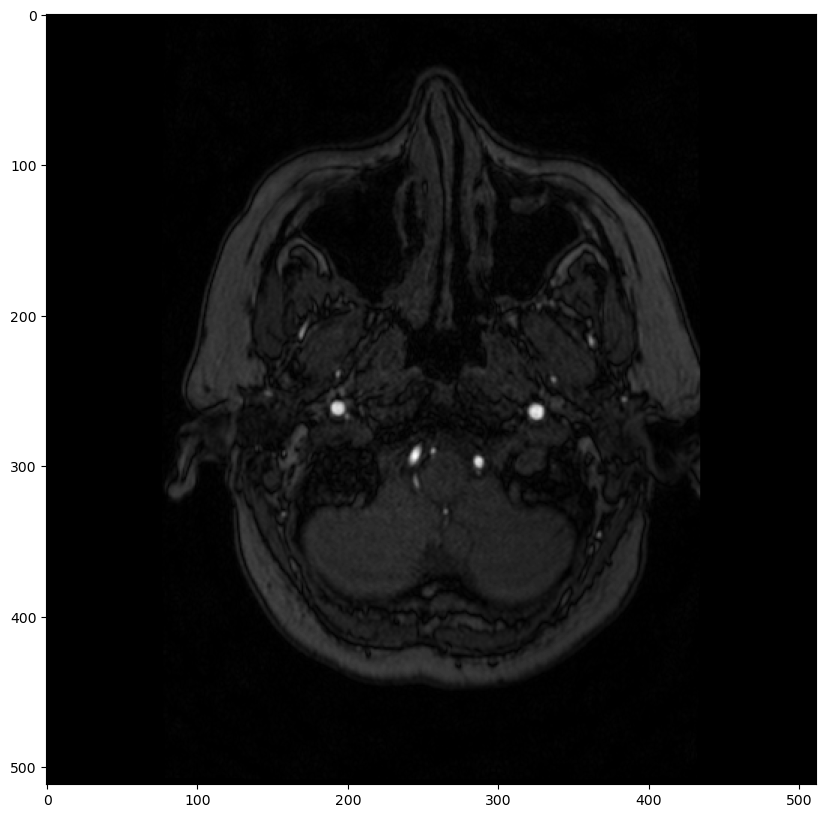

Press Enter to continue to the next image, or type 'q' to quit:  


Annotating image 2/137


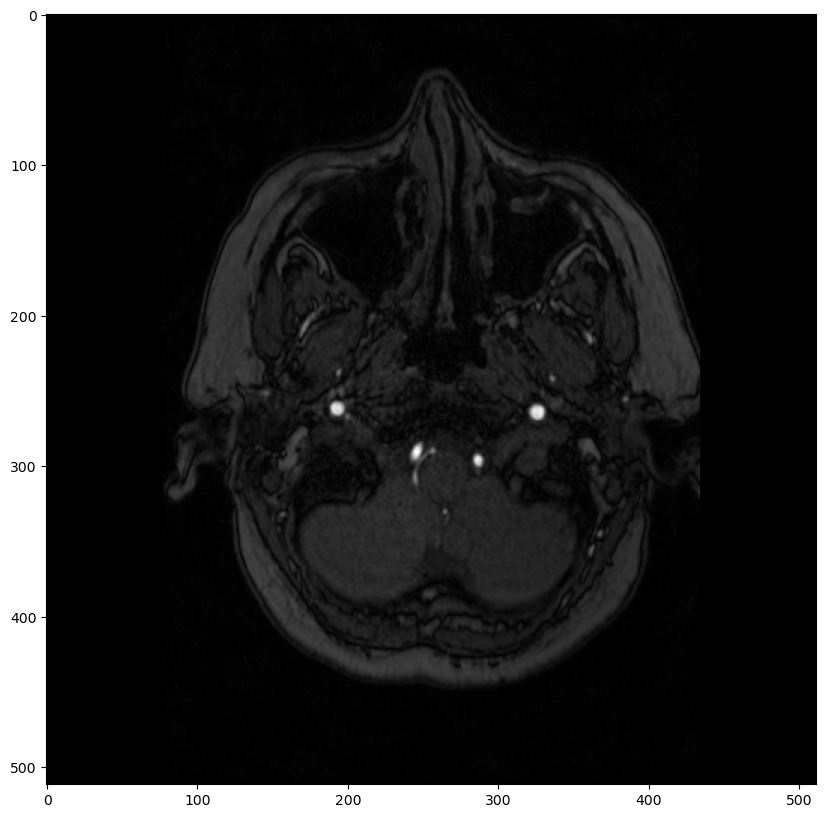

Press Enter to continue to the next image, or type 'q' to quit:  


Annotating image 3/137


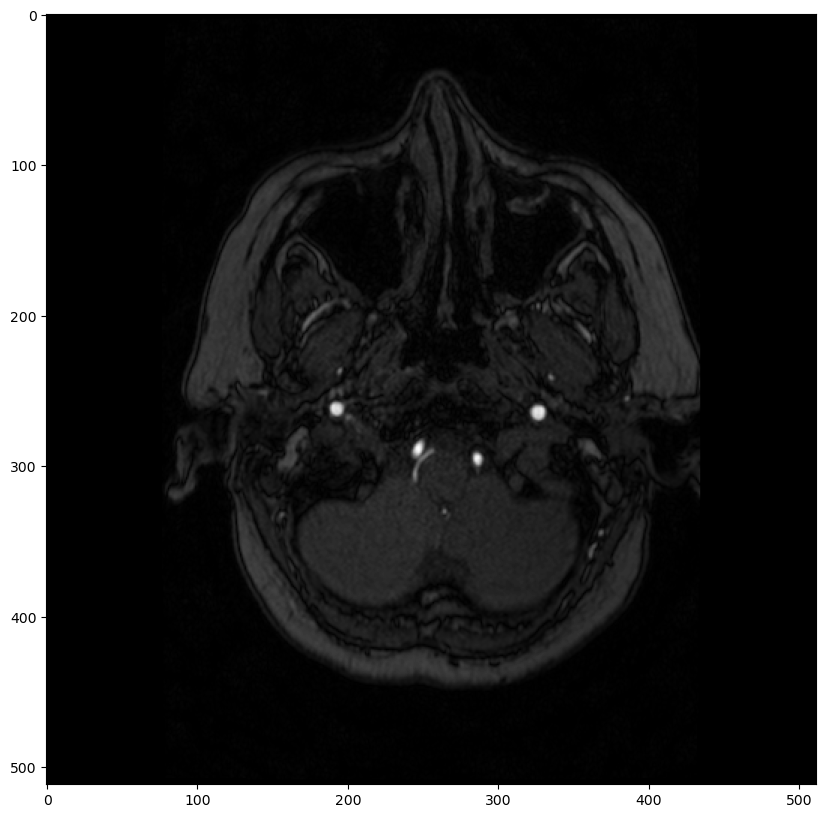

Press Enter to continue to the next image, or type 'q' to quit:  


Annotating image 4/137


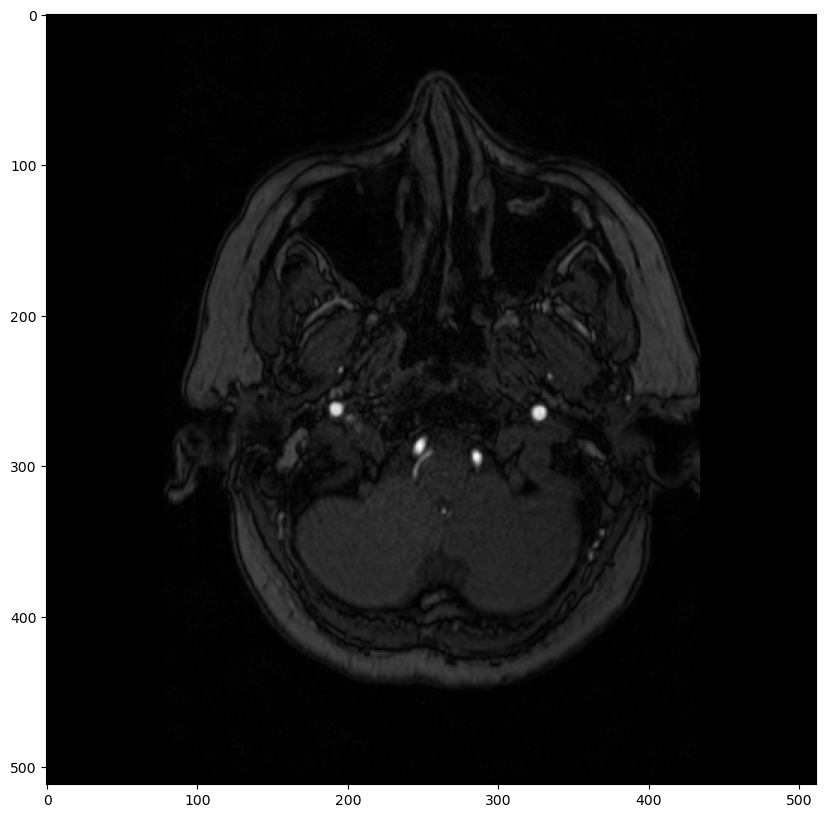

KeyboardInterrupt: Interrupted by user

In [13]:
if __name__ == "__main__":
    try:
        directory_path = "/home/jeremy/Downloads/Circle of Willis"  # Replace with actual path
        
        segmented_series, annotations, evaluation_results = run_segmentation_and_evaluation(directory_path)
        
        if segmented_series is not None:
            print("Segmentation completed.")
            print(f"Processed {len(segmented_series)} images.")
            print(f"Number of annotations: {len(annotations)}")
            print("Evaluation results:", evaluation_results)
        else:
            print("Segmentation failed. Check the log for details.")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        print(f"An error occurred. Please check the log file for details.")

In [ ]:
def integration_test():
    """Perform a comprehensive test of the entire pipeline."""
    try:
        # Load test image
        test_image = np.random.rand(512, 512)  # Replace with actual test image loading
        image_id = "test_integration_001"
        
        # Run preprocessing
        preprocessed_image = preprocess_image(test_image)
        
        # Run segmentation pipeline
        segmented_image, isolated_vessels, vessel_distances = segmentation_pipeline(preprocessed_image)
        
        # Perform manual refinement (this would typically involve user interaction)
        refined_vessels = run_manual_refinement(test_image, segmented_image, isolated_vessels)
        
        # Store results in database
        store_results(image_id, refined_vessels)
        
        # Fetch annotations and update model
        annotations = fetch_annotations_from_db()
        updated_model = update_model(model, annotations)
        
        print("Integration test completed successfully.")
        return True
    except Exception as e:
        print(f"Integration test failed: {str(e)}")
        return False

if __name__ == "__main__":
    integration_test()

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure, restoration

# Import or define all necessary functions
def preprocess_image(image):
    """Preprocess the input image."""
    # Enhance contrast
    image = exposure.equalize_adapthist(image, clip_limit=0.03)
    # Reduce noise
    image = restoration.denoise_nl_means(image, h=0.1, fast_mode=True, patch_size=5, patch_distance=3)
    return image

def segmentation_pipeline(preprocessed_image):
    """Placeholder for segmentation pipeline."""
    # This is a placeholder. Replace with actual segmentation logic.
    segmented_image = preprocessed_image > np.mean(preprocessed_image)
    isolated_vessels = {'vessel_1': segmented_image}
    vessel_distances = np.zeros_like(segmented_image)
    return segmented_image, isolated_vessels, vessel_distances

def run_manual_refinement(image, segmented_image, isolated_vessels):
    """Placeholder for manual refinement interface."""
    # This is a placeholder. Replace with actual manual refinement logic.
    print("Manual refinement interface would run here.")
    return isolated_vessels

def store_results(image_id, refined_vessels):
    """Placeholder for storing results in database."""
    # This is a placeholder. Replace with actual database storage logic.
    print(f"Storing results for image {image_id}")

def load_dicom_series(directory_path):
    """
    Load all DICOM files from a directory and sort them by instance number.
    """
    dicom_files = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(directory_path, filename)
            dcm = pydicom.dcmread(file_path)
            dicom_files.append(dcm)
    
    # Sort by instance number
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    return dicom_files

def comprehensive_dicom_series_test(dicom_directory_path):
    """
    Perform a comprehensive test of the entire pipeline using a series of DICOM files.
    """
    try:
        print("Starting comprehensive DICOM series test...")

        # Step 1: Load DICOM series
        print("Loading DICOM series...")
        dicom_series = load_dicom_series(dicom_directory_path)
        print(f"Loaded {len(dicom_series)} DICOM files.")

        # Step 2: Process each image in the series
        for i, dcm in enumerate(dicom_series):
            print(f"\nProcessing image {i+1}/{len(dicom_series)}")
            
            # Extract image from DICOM
            image = dcm.pixel_array
            print(f"Image shape: {image.shape}")

            # Preprocess image
            print("Preprocessing image...")
            preprocessed_image = preprocess_image(image)

            # Run segmentation pipeline
            print("Running segmentation pipeline...")
            segmented_image, isolated_vessels, vessel_distances = segmentation_pipeline(preprocessed_image)
            print(f"Segmentation complete. {len(isolated_vessels)} vessels identified.")

            # Visualize results
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(image, cmap='gray')
            plt.title(f"Original Image {i+1}")
            plt.subplot(132)
            plt.imshow(preprocessed_image, cmap='gray')
            plt.title(f"Preprocessed Image {i+1}")
            plt.subplot(133)
            plt.imshow(image, cmap='gray')
            plt.imshow(segmented_image, alpha=0.5, cmap='hot')
            plt.title(f"Segmented Image {i+1}")
            plt.show()

            # Test manual refinement interface
            print("Testing manual refinement interface...")
            refined_vessels = run_manual_refinement(image, segmented_image, isolated_vessels)
            print("Manual refinement interface test complete.")

            # Store results in database
            print("Storing results in database...")
            image_id = dcm.SOPInstanceUID  # Use DICOM UID as image identifier
            store_results(image_id, refined_vessels)
            print("Results stored in database.")

        print("\nComprehensive DICOM series test completed successfully.")
        return True

    except Exception as e:
        print(f"Comprehensive DICOM series test failed: {str(e)}")
        return False

# Usage
if __name__ == "__main__":
    dicom_directory_path = "/home/jeremy/Downloads/Circle of Willis"  # Replace with actual path
    test_result = comprehensive_dicom_series_test(dicom_directory_path)
    if test_result:
        print("All systems are functioning as expected.")
    else:
        print("Issues detected in the pipeline. Please review the error messages above.")